In [1]:
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial.transform import Rotation
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(41)
np.random.seed(41)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

Self-interaction of all 3 given shapes can be learnt by one 3-layer NN. Accuracy is really good. Please note it's just 3 shapes of 3 types, we didn't vary axis sizes for any a,b,c values for any particular shape.

This is not something we tried for two-body case (single NN for multiple shapes, or even similar shape but different a,b,c).

Update on 03/20:
+ Noticed I'm projecting force/torque to body frame to avoid inputting to NN the orinetation of the particle, but then sent the orientation as input feature anyway.
+ Couldn't get NN to learn without projecting force/velocity to body frame however. So above thing stands.
+ Final Mean_abs_error: [0.0418 , 0.0378, 0.0426, 0.1030, 0.1289, 0.1425]

In [2]:
def compute_rotvec_batch(rot_partial_flat):
    N = rot_partial_flat.shape[0]
    R_partial = rot_partial_flat.reshape(N, 3, 2)
    R3 = np.cross(R_partial[:, :, 0], R_partial[:, :, 1])
    R_full = np.concatenate((R_partial, R3[:, :, np.newaxis]), axis=2)  # shape (N,3,3)
    #rotvecs = Rotation.from_matrix(R_full).as_rotvec()  # shape (N,3)
    return Rotation.from_matrix(R_full)

def rotate_forces_torques_to_body(forces_lab, torques_lab, rot, lab_to_body=True):
    """
    Rotate forces & torques from lab frame to the body frame (which we'll
    assume is aligned with the spheroid's major axis = z-axis in the body frame).
    
    forces_lab, torques_lab, rotvec all have shape (N,3).
    """
    # Create a batch of Rotation objects from each rotvec
    #rot = Rotation.from_rotvec(rotvec)   # shape: (N,) - a stack of N rotations
    
    # 'inverse=True' rotates vectors *into* the body frame
    forces_body = rot.apply(forces_lab, inverse=lab_to_body)
    torques_body = rot.apply(torques_lab, inverse=lab_to_body)
    
    return forces_body, torques_body

In [3]:

xs,ys = [],[]

xs.append(np.load("../data/X_self_oblateSpheroid_23:07_4.npy"))
ys.append(np.load("../data/Y_self_oblateSpheroid_23:07_4.npy"))

xs.append(np.load("../data/X_self_prolateSpheroid_23:09_4.npy"))
ys.append(np.load("../data/Y_self_prolateSpheroid_23:09_4.npy"))


xs.append(np.load("../data/X_self_sphere_22:42_4.npy"))
ys.append(np.load("../data/Y_self_sphere_22:42_4.npy"))

X = np.concatenate(xs, axis=0)
Y = np.concatenate(ys, axis=0)
orient = compute_rotvec_batch(X[:,3:9]) # convert to Rotation object

# we'll project force and torque to "body frame" (major axis z-axis algined)
# This way, we can ignore particle's orientation for mobility calculation
# We will have to project velocity back to "lab frame" later- after M @ F.

f,t = rotate_forces_torques_to_body(X[:, 9:12], X[:, 12:15], orient)
X[:, 9:12], X[:, 12:15] = f, t
#Y[:, :3], Y[:, 3:] = rotate_forces_torques_to_body(Y[:, :3], Y[:, 3:], orient)



# remove abc
# x = x[:, 3:]

X.shape, Y.shape, X.dtype

((30000, 15), (30000, 6), dtype('float64'))

In [4]:
xs[-1].shape, xs[-2].shape

((10000, 15), (10000, 15))

In [5]:
def shuffle(*arrays):
    # Ensure that all arrays have the same first dimension.
    n = arrays[0].shape[0]
    idx = np.random.permutation(n)
    return tuple(arr[idx] for arr in arrays)

X, Y, orient = shuffle(X,Y, orient)


split_frac = .8
split_point = int(split_frac * X.shape[0])

X_train, X_val = X[:split_point].copy(), X[split_point:].copy()
Y_train, Y_val = Y[:split_point].copy(), Y[split_point:].copy()
orient_train, orient_val = orient[:split_point], orient[split_point:]

# We will only rotate the velocities for training (can't do Rotation stuff w/ pytorch)
Y_train[:, :3], Y_train[:, 3:] = rotate_forces_torques_to_body(
                                    Y_train[:, :3], Y_train[:, 3:], orient_train)

# No need to send Y_val (or any orient) to torch. Validation will happen on CPU
X_train = torch.Tensor(X_train).to(device)
X_val = torch.Tensor(X_val).to(device)
Y_train = torch.Tensor(Y_train).to(device)


X_train.shape, X_val.shape, Y_train.shape, Y_val.shape, X_train.dtype

(torch.Size([24000, 15]),
 torch.Size([6000, 15]),
 torch.Size([24000, 6]),
 (6000, 6),
 torch.float32)

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SelfNetwork(nn.Module):
    """
    Neural network that predicts the 4 key self-mobility scalars for an
    axisymmetric particle in Stokes flow:
       mu_T_parallel, mu_T_perp, mu_R_parallel, mu_R_perp
    """
    def __init__(self, input_dim):
        super(SelfNetwork, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 4),
            #nn.Tanh()
        )

    def forward(self, x):
        return self.layers(x)

    def predict_velocity(self, x, force):
        """
        force:  tensor of shape (batch_size, 6) -> [Fx, Fy, Fz, Tx, Ty, Tz]
        
        Steps:
        1) Forward pass to get the 4 mobility scalars.
        2) Construct the diagonal 3x3 blocks M^{TT}, M^{RR} because
           the particle's major axis is z-axis.
        3) Multiply by force => velocity [Ux, Uy, Uz, Ox, Oy, Oz].
        """
        # 1) Get the mobility scalars
        mus = self.forward(x)  
        mu_T_para = mus[:, 0]  # (batch_size,)
        mu_T_perp = mus[:, 1]
        mu_R_para = mus[:, 2]
        mu_R_perp = mus[:, 3]

        F_3    = force[:, 0:3]  # (batch_size, 3)
        tau_3  = force[:, 3:6]  # (batch_size, 3)

        # 2) For each sample, build M^{TT} and M^{RR} as diag:
        #    M^{TT} = diag(mu_T_perp, mu_T_perp, mu_T_para)
        #    M^{RR} = diag(mu_R_perp, mu_R_perp, mu_R_para)
        # We'll do it in a batched way:
        
        # expand dims for broadcasting
        mu_T_para_ = mu_T_para.view(-1, 1)  # (batch_size,1)
        mu_T_perp_ = mu_T_perp.view(-1, 1)
        mu_R_para_ = mu_R_para.view(-1, 1)
        mu_R_perp_ = mu_R_perp.view(-1, 1)

        # velocity in the z-axis aligned frame:
        #   Ux = mu_T_perp * Fx
        #   Uy = mu_T_perp * Fy
        #   Uz = mu_T_para * Fz
        Ux = mu_T_perp_ * F_3[:,0:1]
        Uy = mu_T_perp_ * F_3[:,1:2]
        Uz = mu_T_para_ * F_3[:,2:3]

        # angular velocity:
        #   Ox = mu_R_perp * Tx
        #   Oy = mu_R_perp * Ty
        #   Oz = mu_R_para * Tz
        Ox = mu_R_perp_ * tau_3[:,0:1]
        Oy = mu_R_perp_ * tau_3[:,1:2]
        Oz = mu_R_para_ * tau_3[:,2:3]

        U = torch.cat([Ux, Uy, Uz], dim=1)       # (batch_size, 3)
        Omega = torch.cat([Ox, Oy, Oz], dim=1)   # (batch_size, 3)

        # Combine
        velocity = torch.cat([U, Omega], dim=1)  # (batch_size, 6)
        return velocity

In [7]:
# class SelfNetwork(nn.Module):
#     def __init__(self, input_dim):
#         super(SelfNetwork, self).__init__()
#         self.layers = nn.Sequential(
#             nn.Linear(input_dim, 128),
#             nn.ReLU(),
#             nn.Linear(128, 64),
#             nn.ReLU(),
#             nn.Linear(64, 128),
#             nn.Relu(),
#             nn.Linear(128, 6),
#         )

#     def forward(self, r):
#         return self.layers(r)


input_dim = 9 # a,b,c and orientation
batch_size = 256
epochs = 200
model = SelfNetwork(input_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs) # noticeably better than StepLR in 1 case


criterion = nn.L1Loss()
n_iter = X_train.shape[0]//batch_size
n_iter, n_iter*batch_size, len(X_train)

(93, 23808, 24000)

In [8]:
losses = []
for epoch in range(epochs):
    model.train()
    avg = 0

    X_train, Y_train = shuffle(X_train, Y_train) #dont forget orient if it comes back
    for it in range(n_iter):
        optimizer.zero_grad()
        
        indices = torch.arange(it*batch_size, (it+1)*batch_size, dtype=torch.int).cuda()
        X_batch = X_train[indices, :9]
        F_batch = X_train[indices, 9:]
        #orient_batch = orient_train[indices]
        Y_batch = Y_train[indices]
        
        batch_output = model.predict_velocity(X_batch, F_batch)

        # Compute loss
        loss = criterion(batch_output, Y_batch)
        
        loss.backward()
        avg += loss.item()
        optimizer.step()
        

    scheduler.step()
    if epoch%5==0:
        print(f'Epoch {epoch}, Loss: {avg/n_iter}')
        losses.append(avg/n_iter)

torch.save(model.state_dict(), "self_interaction.wt")

Epoch 0, Loss: 0.12810947183239205
Epoch 5, Loss: 0.010025778625120399
Epoch 10, Loss: 0.009099976119575321
Epoch 15, Loss: 0.007101088864929093
Epoch 20, Loss: 0.0055107456401631396
Epoch 25, Loss: 0.006082460597177507
Epoch 30, Loss: 0.006060324186178786
Epoch 35, Loss: 0.00422158033426811
Epoch 40, Loss: 0.004593548515150624
Epoch 45, Loss: 0.0039567541811735395
Epoch 50, Loss: 0.003284256265658925
Epoch 55, Loss: 0.002485587335472065
Epoch 60, Loss: 0.0022569553130456516
Epoch 65, Loss: 0.0023198409784605267
Epoch 70, Loss: 0.002049643939401033
Epoch 75, Loss: 0.0016982653923082337
Epoch 80, Loss: 0.0021745838445200714
Epoch 85, Loss: 0.0015259899852436878
Epoch 90, Loss: 0.0017066382964502178
Epoch 95, Loss: 0.0014732682398991078
Epoch 100, Loss: 0.0014559547598373586
Epoch 105, Loss: 0.0009524274338287131
Epoch 110, Loss: 0.001194594718042701
Epoch 115, Loss: 0.0009449475782207383
Epoch 120, Loss: 0.0008867243204706459
Epoch 125, Loss: 0.000984378758334725
Epoch 130, Loss: 0.0007

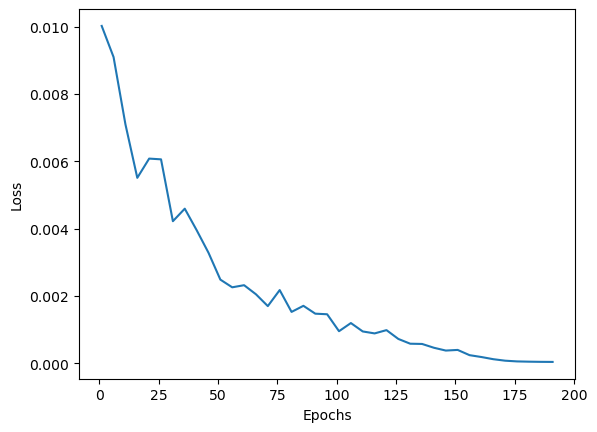

In [9]:
import matplotlib.pyplot as plt
los = losses[1:] # first one is usually too big, messes up the plot
plt.plot(np.arange(len(los))*5+1, los);
plt.ylabel("Loss")
plt.xlabel("Epochs");

In [10]:
model = SelfNetwork(input_dim).to(device)
model.load_state_dict(torch.load("self_interaction.wt", weights_only=True))
model.eval()

with torch.no_grad():
    val_output = model.predict_velocity(X_val[:,:9], X_val[:, 9:])
    val_output = val_output.cpu().numpy()
    val_output[:, :3], val_output[:, 3:] = rotate_forces_torques_to_body(
                            val_output[:, :3], val_output[:, 3:], orient_val, lab_to_body=False) #body to lab

In [11]:
criterion = nn.MSELoss(reduction='none') 
err = criterion(torch.tensor(val_output), torch.tensor(Y_val))

rmse = torch.sqrt(err.mean(axis=0))

print("Root Mean Squared error for each of 6 output variables:\n", rmse)
print("Actual Magnitude:\n ", np.abs(Y_val).mean(axis=0))
print("RMSE:", err.mean()**.5, err.mean())

Root Mean Squared error for each of 6 output variables:
 tensor([1.1856e-04, 1.0949e-04, 1.0460e-04, 4.4747e-05, 4.6067e-05, 4.9066e-05],
       device='cuda:0', dtype=torch.float64)
Actual Magnitude:
  [0.37272603 0.3731415  0.36960977 0.07350573 0.07482097 0.07478078]
RMSE: tensor(8.5165e-05, device='cuda:0', dtype=torch.float64) tensor(7.2530e-09, device='cuda:0', dtype=torch.float64)


In [12]:
#### Median Relative Absolute Error
def mean_abs_err(val_output, val_velocity_tensor, npp=False):
    # 6D vector: median % error for each vel component
    valid_mask = np.abs(val_velocity_tensor) > 1e-6
    
    filtered_y_tensor = np.where(valid_mask, val_velocity_tensor, np.nan)
    relative_error = np.abs((val_output - filtered_y_tensor) / filtered_y_tensor)
    
    a = np.nanmean(relative_error, axis=0)
    return a*100

mean_abs_err(val_output, Y_val)

array([0.0418025 , 0.03781819, 0.04264764, 0.10300191, 0.12894132,
       0.14251576])

In [13]:
frac = rmse/torch.abs(torch.tensor(Y_val)).mean(axis=0)
frac*100

tensor([0.0318, 0.0293, 0.0283, 0.0609, 0.0616, 0.0656], device='cuda:0',
       dtype=torch.float64)

In [14]:
ii = 129
Y_val[ii], val_output[ii], X_val[ii,:3]

(array([ 0.33951872,  0.64921966,  0.68061811, -0.20477137, -0.12085014,
         0.18293166]),
 array([ 0.33956644,  0.64932007,  0.6807363 , -0.20482033, -0.12084848,
         0.18295625], dtype=float32),
 tensor([1., 1., 1.], device='cuda:0'))

## Error depending on shape

In [15]:
sphere_idx = torch.abs(X_val[:,:3].sum(axis=1)-3.0)<.001
sphere_idx = sphere_idx.cpu().numpy()
sphere_idx.sum()

2037

In [16]:
mean_abs_err(val_output[sphere_idx], Y_val[sphere_idx])

array([0.04444997, 0.04147774, 0.04468134, 0.07021803, 0.11121074,
       0.07228087])

In [17]:
prolate = X_val[:,2]==3.0
prolate = prolate.cpu().numpy()
prolate.sum()

1969

In [18]:
mean_abs_err(val_output[prolate], Y_val[prolate])

array([0.03130348, 0.03504064, 0.03588842, 0.11394119, 0.1833849 ,
       0.25881367])

In [19]:
oblate = X_val[:,1]==2.0
oblate = oblate.cpu().numpy()
oblate.sum()

1994

In [20]:
mean_abs_err(val_output[oblate], Y_val[oblate])

array([0.04946534, 0.03682244, 0.04724455, 0.12569063, 0.09329327,
       0.09942543])

In [21]:
sphere_idx.sum()+oblate.sum()+prolate.sum()

6000

In [23]:
Xcu = torch.tensor(X).to(device).float()

with torch.no_grad():
    vv = model.predict_velocity(Xcu[:,:9], Xcu[:, 9:]).cpu().numpy()
    vv[:, :3], vv[:, 3:] = rotate_forces_torques_to_body(
         vv[:, :3], vv[:, 3:], orient, lab_to_body=False
    )

mean_abs_err(vv, Y)

array([0.05133906, 0.05240482, 0.04487908, 0.11913914, 0.14428745,
       0.13743571])

In [25]:
with torch.no_grad():
    val_tr = model.predict_velocity(X_train[:,:9], X_train[:, 9:]).cpu().numpy()
    # val_tr[:, :3], val_tr[:, 3:] = rotate_forces_torques_to_body(
    #                         val_tr[:, :3], val_tr[:, 3:], orient_train, lab_to_body=False) #body to lab

mean_abs_err(val_tr, Y_train.cpu().numpy())

array([0.01754726, 0.01910509, 0.01232178, 0.12044536, 0.0708187 ,
       0.04964599], dtype=float32)